In [1]:
import torch,math,functools
import matplotlib.pyplot as plt
from functools import partial
import pdb
from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from datasets import load_dataset
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
import fastcore.all as fc
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy

In [2]:
# let lr = 5
x = torch.linspace(0,10,10)
lr = 5
print(x,math.pi)

tensor([ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
         8.8889, 10.0000]) 3.141592653589793


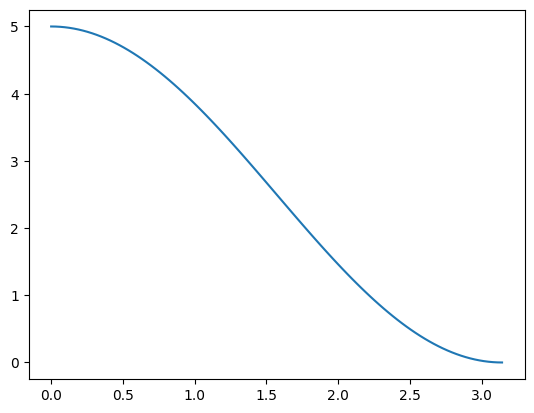

In [3]:
def plot_thing(f,lr,steps):
    x= torch.linspace(0,math.pi,steps)
    plt.plot(x,(f(x) +1)/2 * lr)
plot_thing(partial(torch.cos),lr,steps=100)

### Lets try in learner

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

# CosineAnnealingLR

In [5]:
class CosAnnLR():
    '''
    First Version of CosineAnnealingLR implementation from scratch,
    had to update it so it would work as OneCycle

    This version might be a little fast but take more memory.
    '''

    
    def __init__(self,tmax,optim):
        self.optim = optim
        self.tmax = tmax
        self.lr = optim.param_groups[0]['lr']
        self.values = self._init_values()
        self.cur_step = 0
    
    def _init_values(self):
        return (torch.cos(torch.linspace(0,math.pi,self.tmax))+1)/2*self.lr

    def step(self):
        self.optim.param_groups[0]['lr'] = self.values[self.cur_step]
        self.cur_step +=1

In [6]:
class CosAnnLR():
    '''
    Second Version of CosineAnnealingLR implementation from scratch.
    '''
    def __init__(self,tmax,optim):
        self.optim = optim
        self.lr = optim.param_groups[0]['lr']
        self.tmax = tmax
        self.cur_step = 0
    
    def step(self):
        self.optim.param_groups[0]['lr'] =  (math.cos(self.cur_step/self.tmax * math.pi)+1)/2*self.lr
        self.cur_step +=1

In [7]:
def _lr(cb): return cb.pg['lr']  # Callback that will allow us to record LR during learning.

In [8]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

set_seed(42)

lr,epochs = 1e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(CosAnnLR,tmax)
#sched = partial(lr_scheduler.CosineAnnealingLR,T_max = tmax) # Testing if it works with pytorch's CosineAnnealingLR 

record = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),record]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.806,0.529,0,train
0.853,0.404,0,eval
0.876,0.338,1,train
0.872,0.349,1,eval
0.892,0.295,2,train
0.882,0.326,2,eval
0.904,0.264,3,train
0.887,0.316,3,eval
0.910,0.248,4,train
0.887,0.310,4,eval


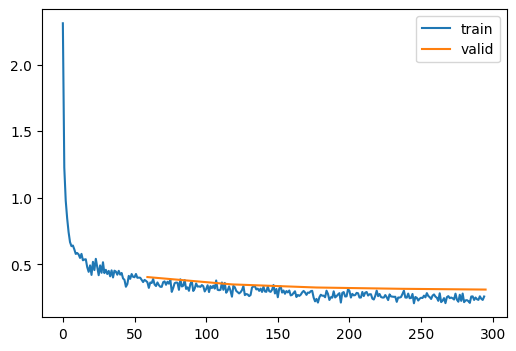

In [9]:
learn.fit(epochs)

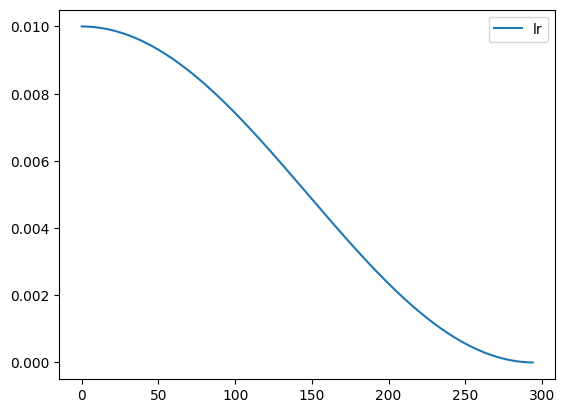

In [10]:
record.plot()

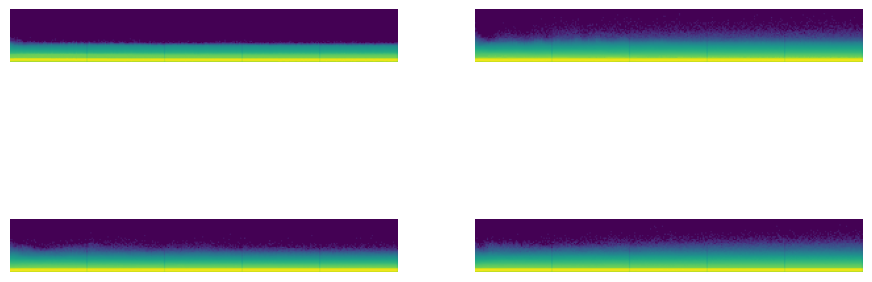

In [11]:
astats.color_dim()

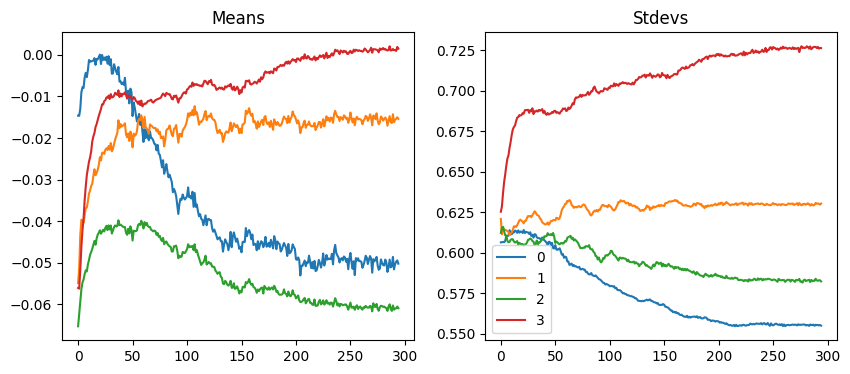

In [12]:
astats.plot_stats()

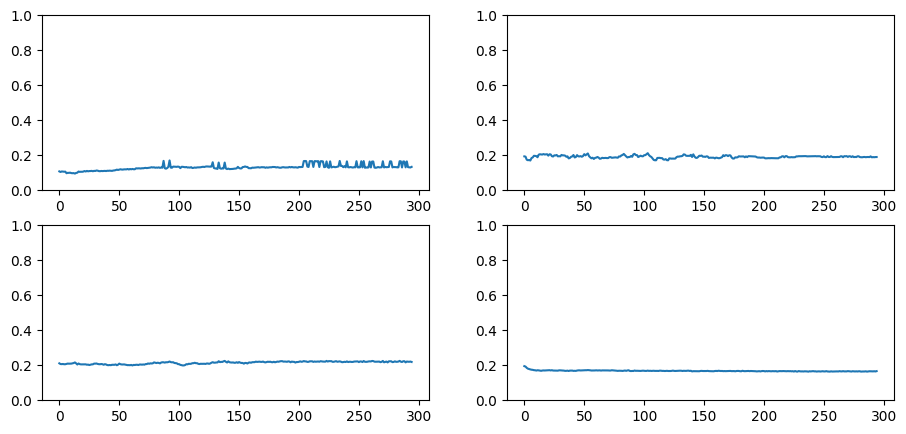

In [13]:
astats.dead_chart()

# OneCycleLR

>Inspiration:  [paper](https://arxiv.org/abs/1803.09820) & fast.ai 22part course \

>Note: \
CLR should specify `minmum` and `maximum` learning rate boundaries and a `step_size`, \
but this implementation doesn't do that. \
Adding minimum and maximum should be pretty straight forward, tho. \
You also might want to add 3rd phase where learning rate is at its maximum for 5-10% of the training.

In [25]:
class OneCycLR:
    def __init__(self, tmax, optim, warm_up:float = 0.30):
        self.optim = optim
        self.initial_lr = self.optim.param_groups[0]['lr']
        self.beta,self.beta_2 = self.optim.param_groups[0]['betas']
        self.max_beta, self.min_beta = self.beta + 0.05, self.beta - 0.05
        self.warm_up = warm_up
        self.warm_up_steps = int(tmax * self.warm_up)
        self.annealing_steps = tmax - self.warm_up_steps
        self.cur_step = 1

    def get_beta(self,phase:float,warming_up: bool):
        if warming_up:
            return self.min_beta + (self.max_beta - self.min_beta) * ((math.cos(math.pi * phase) +1) / 2)
        else:
            return self.max_beta + (self.min_beta - self.max_beta) * ((math.cos(math.pi * phase) +1) / 2)

    
    def step(self):
        
        # warm_up phase
        if self.cur_step <= self.warm_up_steps:
            # Increasing learning rate
            phase = self.cur_step / self.warm_up_steps
            adjusted_lr = (math.cos(phase * math.pi +math.pi)+1)/2*self.initial_lr
            adjusted_beta = self.get_beta(phase, warming_up = True)
        else:
            # Decreasing learning rate
            phase = (self.cur_step - self.warm_up_steps) / self.annealing_steps
            adjusted_lr = (math.cos(phase*math.pi) + 1) / 2 * self.initial_lr
            adjusted_beta = self.get_beta(phase, warming_up = False)

        # adjusted_lr min_max
        self.optim.param_groups[0]['lr'] = adjusted_lr
        self.optim.param_groups[0]['betas'] = (adjusted_beta,self.beta_2)
        self.cur_step += 1

In [26]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

In [27]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

set_seed(42)

lr,epochs = 1e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(OneCycLR,tmax)
#sched = partial(lr_scheduler.OneCycleLR,max_lr = lr,total_steps = tmax) # Testing if it works with pytorch's CosineAnnealingLR 

record = RecorderCB(lr=_lr, mom=_beta1)
xtra = [BatchSchedCB(sched),record]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.727,0.813,0,train
0.824,0.481,0,eval
0.860,0.384,1,train
0.865,0.368,1,eval
0.887,0.310,2,train
0.878,0.338,2,eval
0.902,0.267,3,train
0.885,0.313,3,eval
0.913,0.241,4,train
0.888,0.303,4,eval


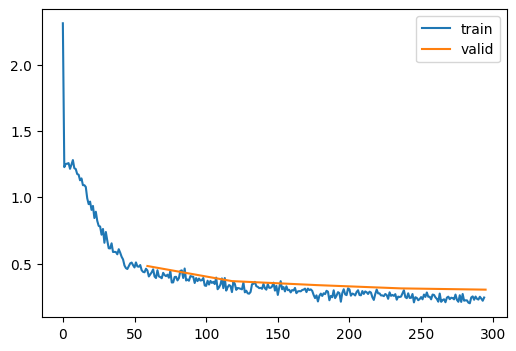

In [28]:
learn.fit(epochs)

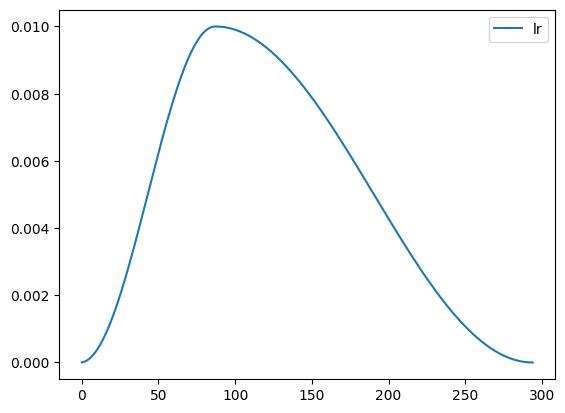

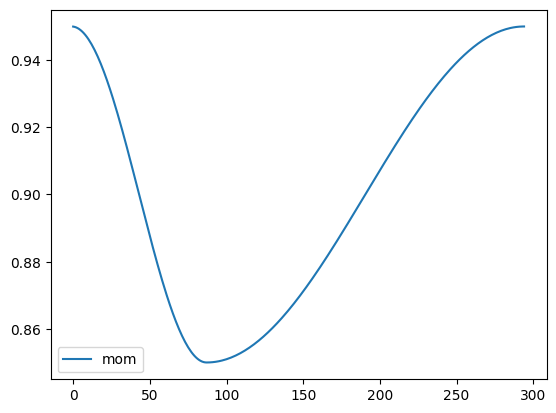

In [29]:
record.plot()

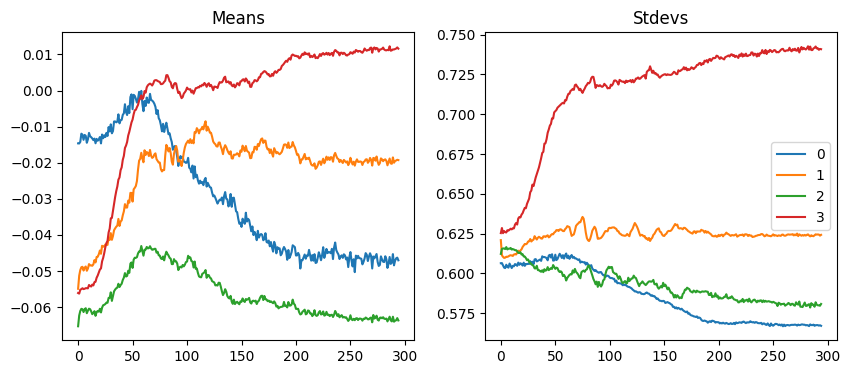

In [30]:
astats.plot_stats()

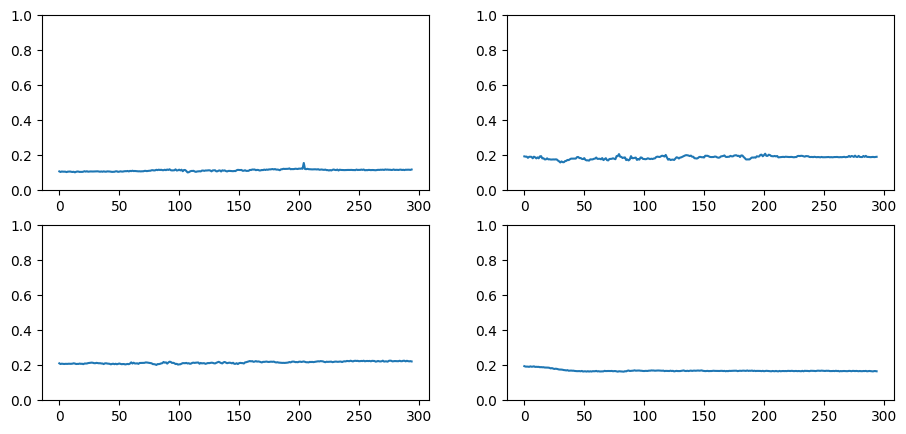

In [31]:
astats.dead_chart()

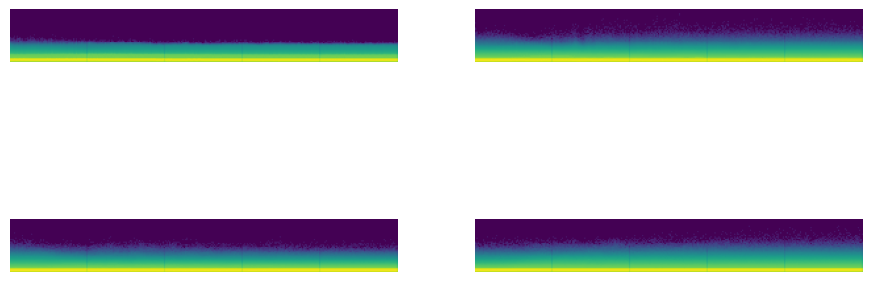

In [32]:
astats.color_dim()